# 根据csv绘制单代号网络图

In [9]:
# 生成示例DataFrame
import pandas as pd

data1 = {
    '活动': ['A', 'B', 'C', 'D'],
    '紧前活动': [None, 'A', 'A', 'B'],
    '紧后活动': ['B', 'C', 'D', None],
    '持续时间': [5, 3, 2, 1]
}

df = pd.DataFrame(data1)

# 将数据框写入csv文件
df.to_csv('data1.csv', index=False)


In [11]:
df

,活动,紧前活动,紧后活动,持续时间
0,A,NaN,B C D,5
1,B,A,E,8
2,C,A,D,2
3,D,B,NaN,1
4,E,B C,G,7
5,F,C D,G,8
6,G,E F,NaN,6


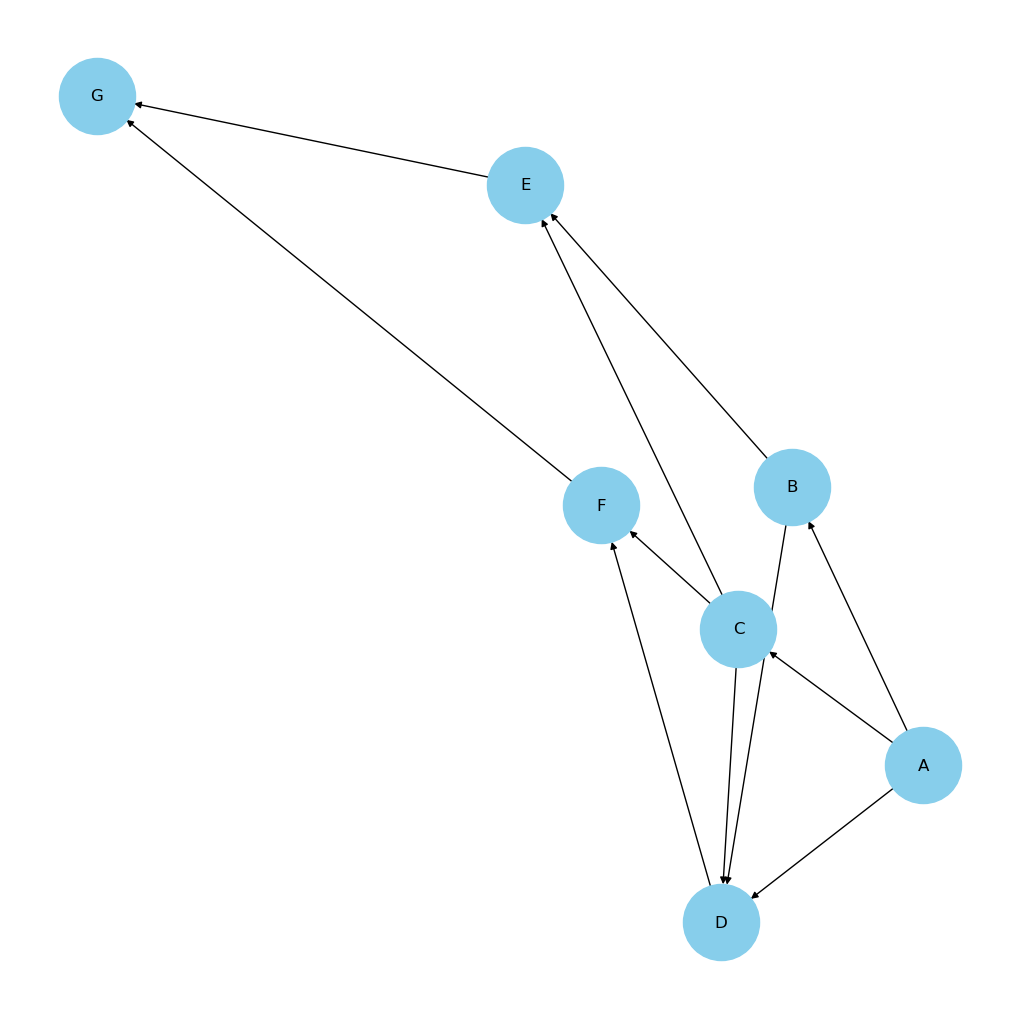

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('data.csv')

# 创建一个有向图
G = nx.DiGraph()

# 遍历每一行数据，添加节点和边
for index, row in df.iterrows():
    node = row['活动']
    G.add_node(node)
    # 处理可能存在的多个紧前活动和紧后活动
    if pd.notnull(row['紧前活动']):
        predecessors = row['紧前活动'].split()
        for pre in predecessors:
            G.add_edge(pre, node)
    if pd.notnull(row['紧后活动']):
        successors = row['紧后活动'].split()
        for suc in successors:
            G.add_edge(node, suc)

# 绘制网络图
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, edge_cmap=plt.cm.Blues)
plt.show()


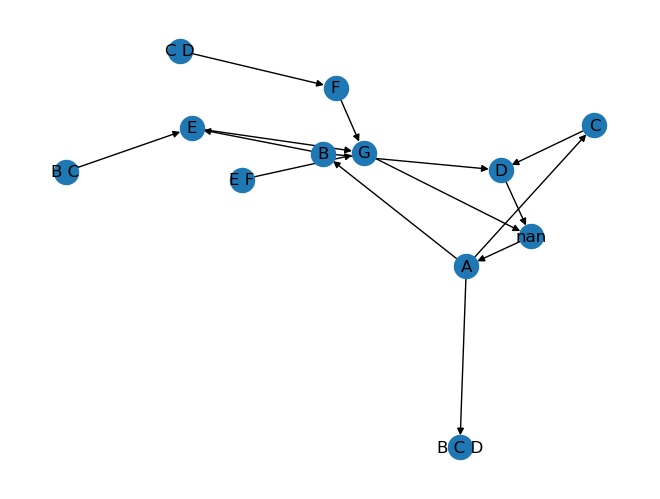

In [10]:
# import pandas as pd
# import networkx as nx
# import matplotlib.pyplot as plt

# # 导入一个csv文件，列名分别为'活动', '紧前活动', '紧后活动', '持续时间'
# df = pd.read_csv('data.csv')

# # 创建一个有向图
# G = nx.DiGraph()

# # 添加节点和边
# for _, row in df.iterrows():
#     G.add_node(row['活动'], duration=row['持续时间'])
#     if row['紧前活动']:
#         G.add_edge(row['紧前活动'], row['活动'])
#     if row['紧后活动']:
#         G.add_edge(row['活动'], row['紧后活动'])

# # 绘制网络图
# nx.draw(G, with_labels=True)
# plt.show()

# # 计算ES, EF, LS, LF, TF, FF
# def calculate_parameters(G, node):
#     duration = nx.get_node_attributes(G, 'duration')
#     es = {}
#     ef = {}
#     ls = {}
#     lf = {}
#     tf = {}
#     ff = {}

#     # Forward pass
#     for n in nx.topological_sort(G):
#         es[n] = max([ef.get(p, 0) for p in G.predecessors(n)])
#         ef[n] = es[n] + duration[n]

#     # Backward pass
#     for n in reversed(list(nx.topological_sort(G))):
#         lf[n] = min([ls.get(s, ef[n]) for s in G.successors(n)])
#         ls[n] = lf[n] - duration[n]

#     # Calculate total float (TF)
#         ff[n] = min([es.get(s, ef[n]) for s in G.successors(n)]) - ef[n] if G.successors(n) else tf[n]

#     return es[node], ef[node], ls[node], lf[node], tf[node], ff[node]
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 导入一个csv文件，列名分别为'活动', '紧前活动', '紧后活动', '持续时间'
df = pd.read_csv('data.csv')

# 创建一个有向图
G = nx.DiGraph()

# 添加节点和边
for _, row in df.iterrows():
    G.add_node(row['活动'], duration=row['持续时间'])
    if row['紧前活动']:
        G.add_edge(row['紧前活动'], row['活动'])
    if row['紧后活动']:
        G.add_edge(row['活动'], row['紧后活动'])

# 去除多余的节点
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

# 绘制网络图
nx.draw(G, with_labels=True)
plt.show()

# 计算ES, EF, LS, LF, TF, FF
def calculate_parameters(G, node):
    duration = nx.get_node_attributes(G, 'duration')
    es = {}
    ef = {}
    ls = {}
    lf = {}
    tf = {}
    ff = {}

    # Forward pass
    for n in nx.topological_sort(G):
        es[n] = max([ef.get(p, 0) for p in G.predecessors(n)])
        ef[n] = es[n] + duration[n]

    # Backward pass
    for n in reversed(list(nx.topological_sort(G))):
        lf[n] = min([ls.get(s, ef[n]) for s in G.successors(n)])
        ls[n] = lf[n] - duration[n]

    # Calculate total float (TF) and free float (FF)
    for n in G.nodes():
        tf[n] = lf[n] - ef[n]
        ff[n] = min([es.get(s, ef[n]) for s in G.successors(n)]) - ef[n] if G.successors(n) else 0

    return es[node], ef[node], ls[node], lf[node], tf[node], ff[node]


In [5]:
def find_start_end_nodes(df):
    start_nodes = df[df['紧前活动'].isna()]['活动'].tolist()
    end_nodes = df[df['紧后活动'].isna()]['活动'].tolist()
    return start_nodes, end_nodes

start_nodes, end_nodes = find_start_end_nodes(df)

# 如果有多个开始或结束节点，你需要根据你的具体情况选择一个。这里我们选择第一个开始节点和第一个结束节点。

start_node = start_nodes[0]
end_node = end_nodes[0]

def find_possible_critical_path(G, start_nodes, end_nodes):
    for _ , __ in start_nodes, end_nodes:
        dict_path = {}
        duration = nx.get_node_attributes(G, 'duration')
        paths = list(nx.all_simple_paths(G, source=start_node, target=end_node))
        max_duration = 0
        critical_path = None
        for path in paths:
            current_duration = sum([duration[node] for node in path])
            if current_duration > max_duration:
                max_duration = current_duration
                critical_path = path
                dict_path[critical_path] = max_duration
    max = 0
    for path in dict_path:
        if dict[path] > max:
            max = dict_path[path]
            critical_path = path
    return path

def find_critical_path(G, start_node, end_node):
    duration = nx.get_node_attributes(G, 'duration')
    paths = list(nx.all_simple_paths(G, source=start_node, target=end_node))
    max_duration = 0
    critical_path = None
    for path in paths:
        current_duration = sum([duration[node] for node in path])
        if current_duration > max_duration:
            max_duration = current_duration
            critical_path = path
    return {tuple(critical_path): max_duration}


In [6]:
# 输出关键路径及其持续时间
critical_path = find_critical_path(G, start_node, end_node)
print(f"Critical Path and Duration: {critical_path}")

# 输出关键路径
critical_path = find_critical_path(G, start_node, end_node)
print(f"Critical Path: {critical_path}")


Critical Path and Duration: {('A', 'B', 'C', 'D'): 11}
Critical Path: {('A', 'B', 'C', 'D'): 11}
